In [42]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import json
from time import time

import numpy as np
import pandas as pd

from scipy import sparse

# spacy, textblob and nltk for language processing
from textblob import TextBlob

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
np.random.seed(42)

In [102]:
pd.reset_option('max_colwidth')

data_dir = Path('data', 'yelp')
yelp_reviews = pd.read_parquet(data_dir / 'user_reviews.parquet')
yelp_reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3495140 entries, 0 to 3495139
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   stars               3495140 non-null  float64
 1   useful              3495140 non-null  int64  
 2   funny               3495140 non-null  int64  
 3   cool                3495140 non-null  int64  
 4   text                3495140 non-null  object 
 5   year                3495140 non-null  int64  
 6   month               3495140 non-null  int64  
 7   review_count        3152850 non-null  float64
 8   useful_user         3152850 non-null  float64
 9   funny_user          3152850 non-null  float64
 10  cool_user           3152850 non-null  float64
 11  fans                3152850 non-null  float64
 12  average_stars       3152850 non-null  float64
 13  compliment_hot      3152850 non-null  float64
 14  compliment_more     3152850 non-null  float64
 15  compliment_prof

In [44]:
yelp_reviews.sample(5)

,stars,useful,funny,cool,text,year,month,review_count,useful_user,funny_user,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,member_yrs
525305,4.0,1,0,0,Stopped in for breakfast. Great atmosphere and...,2019,9,26.0,14.0,3.0,...,1.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,0.0,7.0
65915,4.0,0,0,0,Absolutely fantastic place - we came here at 5...,2015,1,94.0,259.0,22.0,...,0.0,0.0,0.0,4.0,1.0,3.0,3.0,3.0,0.0,11.0
2579520,5.0,0,0,0,Amazing!!! We travel the US and love trying ne...,2021,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
647056,1.0,3,0,0,These people are scam artists. Read the revie...,2017,8,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
951223,5.0,4,0,2,Finally a decent margarita! I can't testify to...,2017,6,453.0,1815.0,504.0,...,1.0,1.0,0.0,26.0,45.0,59.0,59.0,49.0,50.0,6.0


In [45]:
yelp_dir = Path('results', 'yelp')

text_features_dir = yelp_dir / 'data'
if not text_features_dir.exists():
    text_features_dir.mkdir(exist_ok=True, parents=True)

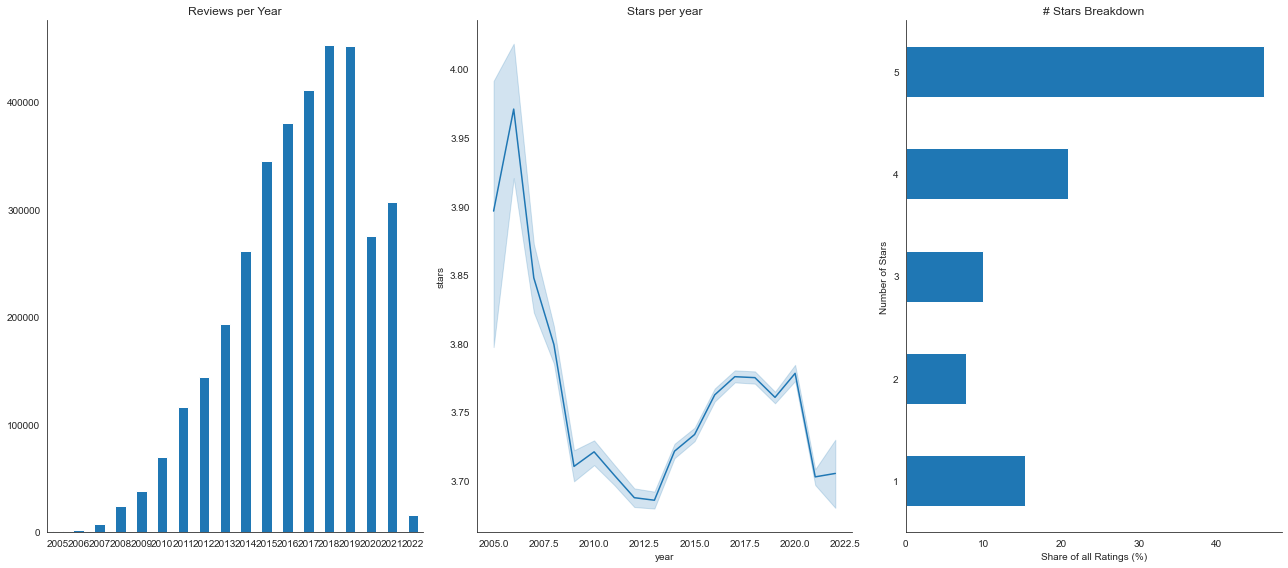

In [46]:
# Reviews & Stars by Year
fig, axes = plt.subplots(ncols=3, figsize=(18, 8))
yelp_reviews.year.value_counts().sort_index().plot.bar(title='Reviews per Year', ax=axes[0], rot=0);
sns.lineplot(x='year', y='stars', data=yelp_reviews, ax=axes[1])
axes[1].set_title('Stars per year')

stars_dist = yelp_reviews.stars.value_counts(normalize=True).sort_index().mul(100)
stars_dist.index = stars_dist.index.astype(int)
stars_dist.plot.barh(title='# Stars Breakdown', ax=axes[2])
axes[2].set_xlabel('Share of all Ratings (%)')
axes[2].set_ylabel('Number of Stars');

sns.despine()
fig.tight_layout();
# since the limited memory, the below graphs exhibits half of the data collected
# (totally 6 million reviews collected. 3 million reviews used here)

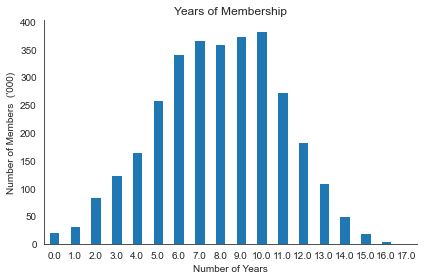

In [47]:
# Years of Membership Breakdown
ax = yelp_reviews.member_yrs.value_counts().div(1000).sort_index().plot.bar(title='Years of Membership', rot=0)
ax.set_xlabel('Number of Years')
ax.set_ylabel("Number of Members  ('000)")
sns.despine()
plt.tight_layout()

In [48]:
# Create train-test split
train = yelp_reviews[yelp_reviews.year < 2019].sample(frac=.25)
test = yelp_reviews[yelp_reviews.year == 2019]
print(f'# Training Obs: {len(train):,.0f} | # Test Obs: {len(test):,.0f}')

# Training Obs: 611,406 | # Test Obs: 452,065


In [49]:
# train.to_parquet(text_features_dir / 'train.parquet')
# test.to_parquet(text_features_dir / 'test.parquet')
del yelp_reviews

In [50]:
# Reload stored data
train = pd.read_parquet(text_features_dir / 'train.parquet')
test = pd.read_parquet(text_features_dir / 'test.parquet')

In [51]:
# Create Yelp review document-term matrix
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000)
train_dtm = vectorizer.fit_transform(train.text)

# sparse.save_npz(text_features_dir / 'train_dtm', train_dtm)
test_dtm = vectorizer.transform(test.text)
# sparse.save_npz(text_features_dir / 'test_dtm', test_dtm)

train_dtm

<611406x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 27068040 stored elements in Compressed Sparse Row format>

In [52]:
# Reload stored data
train_dtm = sparse.load_npz(text_features_dir / 'train_dtm.npz')
test_dtm = sparse.load_npz(text_features_dir / 'test_dtm.npz')

In [53]:
# One-hot-encoding
df = pd.concat([train.drop(['text', 'stars'], axis=1).assign(source='train'),
                test.drop(['text', 'stars'], axis=1).assign(source='test')])
uniques = df.nunique()
binned = pd.concat([(df.loc[:, uniques[uniques > 20].index]
                     .apply(pd.qcut, q=10, labels=False, duplicates='drop')),
                    df.loc[:, uniques[uniques <= 20].index]], axis=1)
binned.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063471 entries, 404137 to 3489775
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   useful              1063471 non-null  int64  
 1   funny               1063471 non-null  int64  
 2   cool                1063471 non-null  int64  
 3   review_count        953817 non-null   float64
 4   useful_user         953817 non-null   float64
 5   funny_user          953817 non-null   float64
 6   cool_user           953817 non-null   float64
 7   fans                953817 non-null   float64
 8   average_stars       953817 non-null   float64
 9   compliment_hot      953817 non-null   float64
 10  compliment_more     953817 non-null   float64
 11  compliment_profile  953817 non-null   float64
 12  compliment_cute     953817 non-null   float64
 13  compliment_list     953817 non-null   float64
 14  compliment_note     953817 non-null   float64
 15  compliment

In [73]:
binned.sample(10)

,useful,funny,cool,review_count,useful_user,funny_user,cool_user,fans,average_stars,compliment_hot,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,year,month,member_yrs,source
2577527,1,0,0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,9.0,test
1653326,0,0,0,6.0,7.0,5.0,5.0,2.0,4.0,1.0,...,1.0,0.0,2.0,2.0,2.0,0.0,2007,8,14.0,train
234787,0,0,0,8.0,8.0,6.0,6.0,3.0,9.0,2.0,...,3.0,4.0,3.0,3.0,2.0,2.0,2018,5,5.0,train
339915,2,0,0,9.0,9.0,7.0,7.0,4.0,4.0,3.0,...,4.0,4.0,4.0,4.0,3.0,2.0,2012,5,11.0,train
5799,0,0,0,2.0,1.0,0.0,1.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2017,7,4.0,train
3391591,2,0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,11,2.0,test
3151484,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2014,3,NaN,train
235535,0,0,0,6.0,6.0,4.0,3.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2017,3,9.0,train
2419142,3,0,0,8.0,7.0,5.0,5.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,2016,1,13.0,train
1860017,0,0,0,8.0,7.0,5.0,5.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,12,8.0,test


In [74]:
# One-Hot encoding
dummies = pd.get_dummies(binned, columns=binned.columns.drop('source'), drop_first=True)
# dummies.info()
dummies.shape

(1063471, 119)

In [77]:
train_dummies = dummies[dummies.source=='train'].drop('source', axis=1)
# train_dummies.info()
train_dummies.sample(8)

,useful_1,useful_2,useful_3,funny_1,cool_1,review_count_1.0,review_count_2.0,review_count_3.0,review_count_4.0,review_count_5.0,...,member_yrs_8.0,member_yrs_9.0,member_yrs_10.0,member_yrs_11.0,member_yrs_12.0,member_yrs_13.0,member_yrs_14.0,member_yrs_15.0,member_yrs_16.0,member_yrs_17.0
1821130,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
456175,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2993237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2834894,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3038052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3415024,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3380280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1481827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [56]:
# Train set
# Cast other feature columns to float and convert to a sparse matrix.
train_numeric = sparse.csr_matrix(train_dummies.astype(np.uint8))
train_numeric.shape

(611406, 118)

In [57]:
# Combine sparse matrices.
train_dtm_numeric = sparse.hstack((train_dtm, train_numeric))
train_dtm_numeric.shape

(611406, 10118)

In [58]:
# sparse.save_npz(text_features_dir / 'train_dtm_numeric', train_dtm_numeric)

In [59]:
# Repeat for test set
test_dummies = dummies[dummies.source=='test'].drop('source', axis=1)
test_numeric = sparse.csr_matrix(test_dummies.astype(np.int8))
test_dtm_numeric = sparse.hstack((test_dtm, test_numeric))
test_dtm_numeric.shape

(452065, 10118)

In [60]:
# sparse.save_npz(text_features_dir / 'test_dtm_numeric', test_dtm_numeric)

In [61]:
# Reload stored data
train_dtm_numeric = sparse.load_npz(text_features_dir / 'train_dtm_numeric.npz')
test_dtm_numeric = sparse.load_npz(text_features_dir / 'test_dtm_numeric.npz')

In [62]:
# Benchmark Accuracy
accuracy, runtime = {}, {}
predictions = test[['stars']].copy()
# np.full_like: Return a full array with the same shape and type as a given array
naive_prediction = np.full_like(predictions.stars, fill_value=train.stars.mode().iloc[0])
naive_benchmark = accuracy_score(predictions.stars, naive_prediction)

naive_benchmark

0.5089356619070267

In [63]:
# Model Evaluation Helper
result = 'nb_text'

def evaluate_model(model, X_train, X_test, name, store=False):
    start = time()
    model.fit(X_train, train.stars)
    runtime[name] = time() - start
    predictions[name] = model.predict(X_test)
    accuracy[result] = accuracy_score(test.stars, predictions[result])
    if store:
        joblib.dump(model, f'results/{result}.joblib')

In [64]:
# Multinomial naive Bayes model
nb = MultinomialNB()

evaluate_model(nb, train_dtm, test_dtm, result, store=False)

In [65]:
accuracy[result]

0.6416245451428445

In [66]:
# Confusion Matrix
stars = index = list(range(1, 6))
pd.DataFrame(confusion_matrix(test.stars, predictions[result]), columns=stars, index=stars)

,1,2,3,4,5
1,58670,14927,2675,1024,1431
2,10184,12517,6867,1702,1098
3,4740,7325,14490,8199,2540
4,2947,2272,8979,40628,18778
5,10866,1514,2924,51017,163751


In [67]:
# Text & Numeric Features
result = 'nb_combined'
evaluate_model(nb, train_dtm_numeric, test_dtm_numeric, result, store=False)

In [68]:
accuracy[result]

0.6514129605255882

In [69]:
# Multinomial Logistic Regression
Cs = np.logspace(-5, 5, 11)

# Text Features
log_reg_text_accuracy = {}
log_reg_text_runtime = []
for i, C in enumerate(Cs):
    start = time()
    model = LogisticRegression(C=C, multi_class='multinomial', solver='lbfgs')

    model.fit(train_dtm, train.stars)
    log_reg_text_runtime.append(time() - start)
    log_reg_text_accuracy[C] = accuracy_score(test.stars, model.predict(test_dtm))

    print(f'{C:12.5f}: {log_reg_text_runtime[i]:.2f}s | {log_reg_text_accuracy[C]:.2%}', flush=True)

     0.00001: 16.57s | 55.89%
     0.00010: 19.09s | 66.27%
     0.00100: 47.67s | 71.31%
     0.01000: 46.11s | 72.77%
     0.10000: 43.95s | 72.68%
     1.00000: 46.20s | 72.46%
    10.00000: 46.13s | 72.46%
   100.00000: 47.53s | 72.41%
  1000.00000: 47.97s | 72.44%
 10000.00000: 46.19s | 72.47%
100000.00000: 48.00s | 72.51%


In [89]:
pd.Series(log_reg_text_accuracy).to_csv(yelp_dir / 'logreg_text.csv')
accuracy['lr_text'] = pd.Series(log_reg_text_accuracy).max()
runtime['lr_text'] = np.mean(log_reg_text_runtime)

In [90]:
# Combined Features
log_reg_comb_accuracy = {}
log_reg_comb_runtime = []
for i, C in enumerate(Cs):
    start = time()
    model = LogisticRegression(C=C, multi_class='multinomial', solver='lbfgs')

    model.fit(train_dtm_numeric, train.stars)
    log_reg_comb_runtime.append(time() - start)
    log_reg_comb_accuracy[C] = accuracy_score(test.stars, model.predict(test_dtm_numeric))

    print(f'{C:12.5f}: {log_reg_comb_runtime[i]:.2f}s | {log_reg_comb_accuracy[C]:.2%}', flush=True)

     0.00001: 15.97s | 56.82%
     0.00010: 25.04s | 68.34%
     0.00100: 61.82s | 72.50%
     0.01000: 52.34s | 73.15%
     0.10000: 53.57s | 72.59%
     1.00000: 52.26s | 72.40%
    10.00000: 52.58s | 72.38%
   100.00000: 51.90s | 72.35%
  1000.00000: 51.95s | 72.21%
 10000.00000: 52.21s | 72.15%
100000.00000: 52.59s | 72.36%


In [91]:
pd.Series(log_reg_comb_accuracy).to_csv(yelp_dir / 'logreg_combined.csv')
accuracy['lr_comb'] = pd.Series(log_reg_comb_accuracy).max()
runtime['lr_comb'] = np.mean(log_reg_comb_runtime)

In [92]:
# Multiclass gradient boosting with LightGBM
lgb_train = lgb.Dataset(data=train_dtm_numeric.tocsr().astype(np.float32), label=train.stars.sub(1),
                        categorical_feature=list(range(train_dtm_numeric.shape[1])))
lgb_test = lgb.Dataset(data=test_dtm_numeric.tocsr().astype(np.float32),  label=test.stars.sub(1),
                       reference=lgb_train)
param = {'objective': 'multiclass', 'metrics': ['multi_error'], 'num_class': 5}
booster = lgb.train(params=param, train_set=lgb_train, num_boost_round=2000, early_stopping_rounds=25,
                    valid_sets=[lgb_train, lgb_test], verbose_eval=25)

booster.save_model((yelp_dir / 'lgb_model.txt').as_posix());
y_pred_class = booster.predict(test_dtm_numeric.astype(float))

accuracy['lgb_comb'] = accuracy_score(test.stars, y_pred_class.argmax(1) + 1)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.637143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42503
[LightGBM] [Info] Number of data points in the train set: 611406, number of used features: 10117
[LightGBM] [Info] Start training from score -1.977768
[LightGBM] [Info] Start training from score -2.499129
[LightGBM] [Info] Start training from score -2.211830
[LightGBM] [Info] Start training from score -1.442274
[LightGBM] [Info] Start training from score -0.835688
Training until validation scores don't improve for 25 rounds
[25]	training's multi_error: 0.394103	valid_1's multi_error: 0.327276
[50]	training's multi_error: 0.361253	valid_1's multi_error: 0.308588
[75]	training's multi_error: 0.345623	valid_1's multi_error: 0.298944
[100]	training's multi_error: 0.335075	valid_1's multi_error: 0.292062
[125]	training's multi_erro

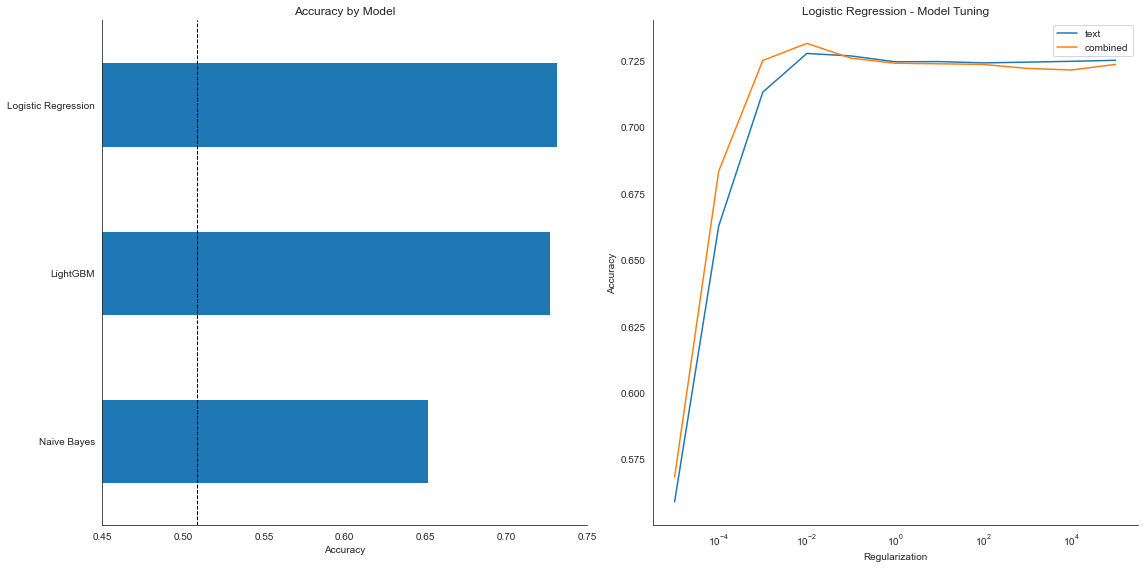

In [93]:
# Comparison
model_map = {'nb_combined': 'Naive Bayes', 'lr_comb': 'Logistic Regression', 'lgb_comb': 'LightGBM'}
accuracy_ = {model_map[k]: v for k, v in accuracy.items() if model_map.get(k)}
log_reg_text = pd.read_csv(yelp_dir / 'logreg_text.csv', index_col=0, squeeze=True)
log_reg_combined = pd.read_csv(yelp_dir / 'logreg_combined.csv', index_col=0, squeeze=True)
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
pd.Series(accuracy_).sort_values().plot.barh(ax=axes[0], xlim=(.45, .75), title='Accuracy by Model')
axes[0].axvline(naive_benchmark, ls='--', lw=1, c='k')

log_reg = (log_reg_text.to_frame('text').join(log_reg_combined.to_frame('combined')))
log_reg.plot(logx=True, ax=axes[1], title='Logistic Regression - Model Tuning')
axes[1].set_xlabel('Regularization')
axes[1].set_ylabel('Accuracy')
axes[0].set_xlabel('Accuracy')
sns.despine()
fig.tight_layout()

In [94]:
# Textblob for Sentiment Analysis
sample_review = train.text.sample(1).iloc[0]
print(sample_review)

This place kills it on food, drinks, and friendly service. What's not to love? I was only in New Orleans for 4 days and went there twice for brunch and twice for dinner! Unusual and delicious wines by the glass. The tuna crudo was amazing, as was the braised rabbit with sweet potato gnocchi and for brunch, house made chicken sausage with polenta and blistered cherry tomatoes. Attentive and relaxed service( even solo at the bar) and a great, open feel to the space. GO!


In [95]:
# Polarity ranges from -1 (most negative) to 1 (most positive).
TextBlob(sample_review).sentiment.polarity

0.31628787878787873

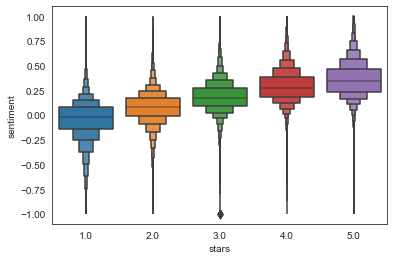

In [96]:
# Define a function that accepts text and returns the polarity.
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

train['sentiment'] = train.text.apply(detect_sentiment)
sample_reviews = train[['stars', 'text']].sample(100000)

# Create a new DataFrame column for sentiment (very SLOW)
sample_reviews['sentiment'] = sample_reviews.text.apply(detect_sentiment)

# Box plot of sentiment grouped by stars
sns.boxenplot(x='stars', y='sentiment', data=train);

In [106]:
# Reviews with most negative sentiment
train[train.sentiment == -1].text.head()

820883                       Waitress was awful. Kept putting drinks on the table no one ordered. Couldn't stop to hear what we were saying
2509                     Terrible service at this Domino's... They don't seem to have the ability to fulfill orders promptly and correctly.
814089                                             Yuck.  The food choices for a vegan are terrible. The steamed tofu stuff was disgusting.
2596116    I have been trying to get a refund for a month now.  Terrible customer service.  Now they want me to find their tracking number.
1061848                                                                                  neighborhood pizza.  service is the worst ever !!!
Name: text, dtype: object

In [107]:
# Negative sentiment in a 5-star review
train.loc[(train.stars == 5) & (train.sentiment < -0.3), 'text'].head(3)

1697076    Kelly S. must be smoking crack to say Sonny's has the worst steaks..\n\nGeno's, Jim's, Pats and Tony Luke's all take a backseat to Sonny's.  \n\nTheir menu is simple like any cheese steak eatery, but their quality choice of ingredients defiantly shows.  \n\nI'd recomend Sonny's to anyone who is looking for a cheese steak.  \n\nOh yeah, they just started to deliver too!
1673968                                                                                                                                                                                                                                                                              Needed a caffeine fix while in the Madison area, a place sadly lacking in coffee houses. Before resigning
358675                                                                                                       I used to live two blocks away from this pathmark and I've never been disappointed. Their fried chicken from the deli rviels 

In [105]:
# Positive sentiment in a 1-star review
train.loc[(train.stars == 1) & (train.sentiment > 0.5), 'text'].head(1)

1961389    Greasy, overcrowded, and pricey seafood. The food was "good" to my company, but then again I'm not a seafood fan.
Name: text, dtype: object